In [1]:
from IPython.display import display
from IPython.display import Image
import os # Locate files

# A Python tutorial on validating gVirtualXRay:
## Volume reconstructed from X-ray projections simulated with gVirtualXRay vs. the [Digimouse](https://neuroimage.usc.edu/neuro/Digimouse)
### CT data acquisition and reconstruction
#### Author: F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable that can be used to simulate CT acquisition data. 

**Material and Methods:** We simulate X-ray data of a virtual object corresponding to the [Digimouse](https://neuroimage.usc.edu/neuro/Digimouse) phantom. 

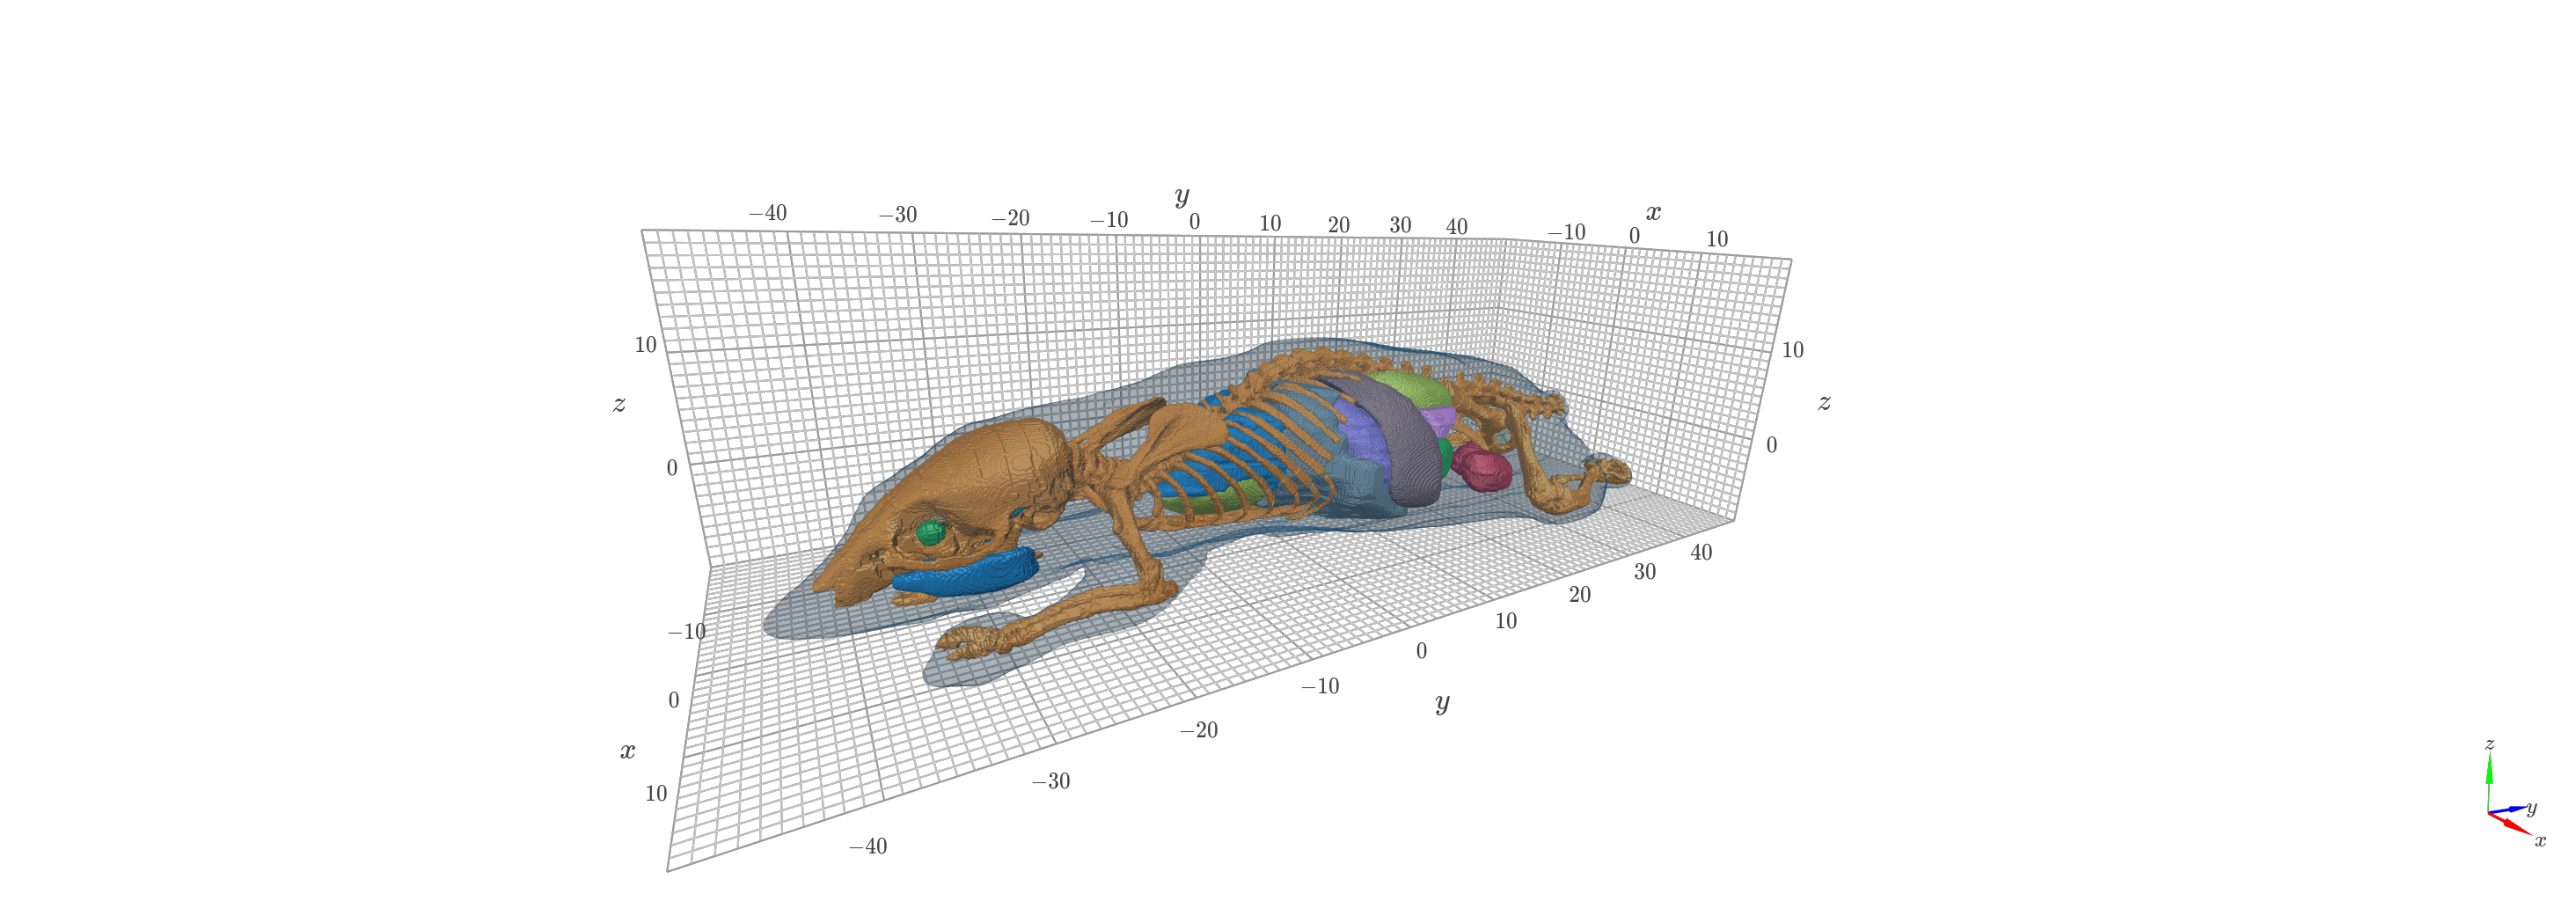

In [2]:
Image(filename="digimouse_visualisation.png", width=400)

The detector size is 106.23x20.80 mm. There are 1062x208 pixels. A parallel monochromatic source of 511 keV is used (i.e. the energy of annihilation photons in PET). 

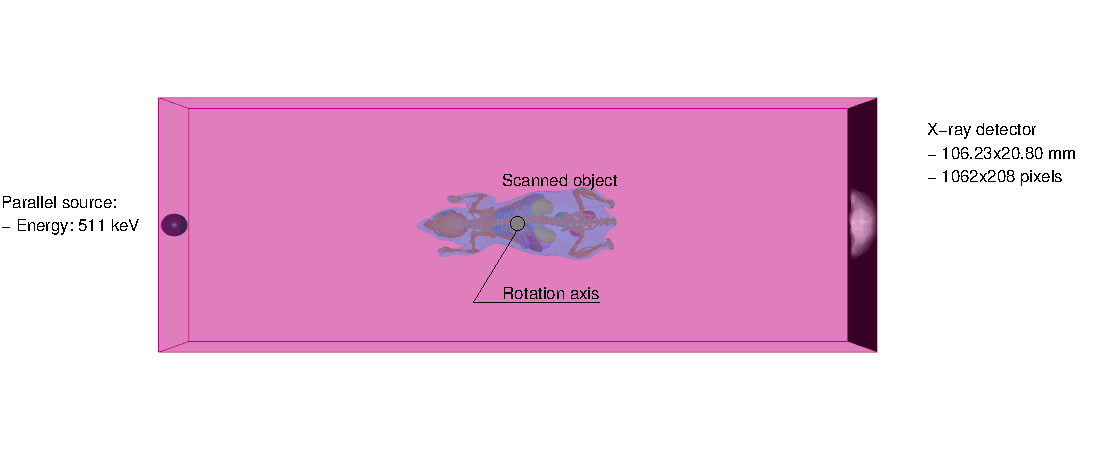

In [3]:
Image(filename="digimouse/setup.png")
# Image(filename="digimouse_3d-env.png", width=400)

<!-- The scanned object is made of two materials, a background plate of "muscle", and a new year message of bone (cortical). We use the definitions of tissue substitutes provided in the ICRU Report 44 by the International Commission on Radiation Units and Measurements. The material composition is available at https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html. -->

Two set of 500 X-ray projections around the phantom is generated:

- Digitally reconstructed radiographs (DRRs) of the phantom are generated using a Radon transform. 
- Surface meshes are generated from segmentations of the phantom and X-ray radiographs are simulated using gVirtualXRay.

The corresponding CT volume are reconstructed using the gridrec implementation of Tomopy.

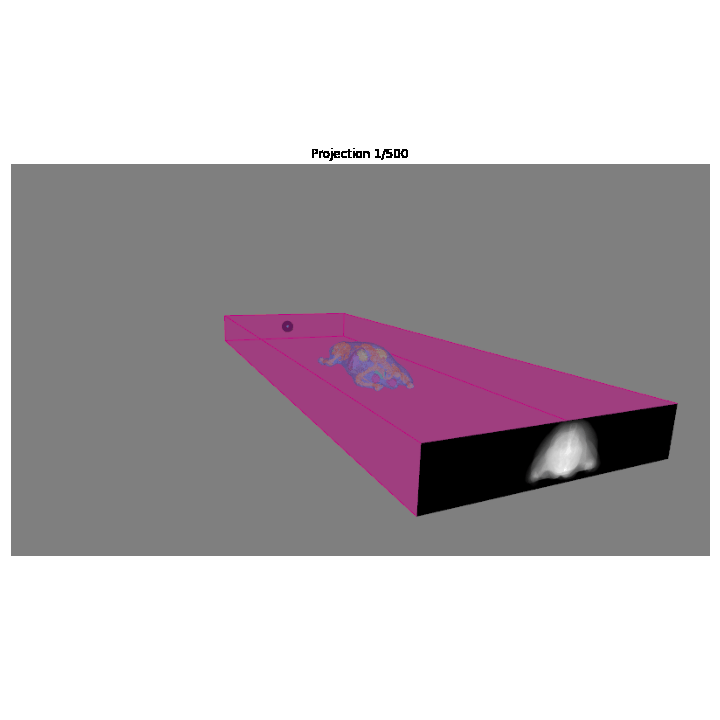

In [4]:
with open('./plots/digimouse_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

**Results:** We compared the simulated projections with the projections computed from the numerical phantom. We also compare the volume reconstructed from the simulated projections with 1) the phantom, and 2) the volume reconstructed from the phantom projections. We use the [zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) and [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 

| Image 1 | Image 2 | ZNCC | SSIM |
|---------|---------|------|------|
| Phantom | CT reconstruction from phantom sinogram | 99.25% | 0.61 |
| Phantom | CT reconstruction from simulated sinogram | 99.07% | 0.57 |
| CT reconstruction from phantom sinogram | CT reconstruction from simulated sinogram | 99.80% | 0.92 |
| Phantom sinogram | Simulated sinogram | 100% | 1 |

The simulated projections are perfectly correlated with the projections generated from the phantom using the Radon transform. 
The **ZNCC is 100%** and **SSIM is 1.00**. They cannot be better. The **ZNCC and SSIM of their CT reconstructions are 99.80% and 0.92** respectively.
Both tests demonstrate the validity of the simulated data.

## Import Python packages

In [5]:
# tomography_backend = "scikit-image"
# tomography_backend = "tigre"
tomography_backend = "tomopy"

In [6]:
%matplotlib inline 

import os
import math # For pi

import matplotlib
import matplotlib.pyplot as plt
from skimage import draw
import numpy as np
import pandas as pd
import SimpleITK as sitk
import copy


if tomography_backend == "tomopy":
    import tomopy
elif tomography_backend == "tigre":
    import tigre
    import tigre.algorithms as algs
    import tomopy
elif tomography_backend == "scikit-image":
    from skimage.transform import iradon
    from skimage.transform import radon
else:
    IOError("No tomography reconstruction backend")

from skimage.draw import disk
from skimage.transform import resize # Resample the images
from math import floor
import k3d, base64
from stl import mesh

import imageio
from tifffile import imsave # Write TIFF files

import datetime # For the runtime

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

import gvxrPython3 as gvxr
import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

from sitk2vtk import sitk2vtk

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


## Define constants for this experiment

In [7]:
number_of_projections = 500;
span = 180
angular_step = span / number_of_projections;
theta_deg = np.linspace(0.0, angular_step * number_of_projections, num=number_of_projections, endpoint=False)

In [8]:
print("Number of projections:", theta_deg.shape[0])
print("Angle between successive projections:", angular_step)
print("First angle:", theta_deg[0])
print("Last angle:", theta_deg[-1])

Number of projections: 500
Angle between successive projections: 0.36
First angle: 0.0
Last angle: 179.64


## Define some useful functions

In [9]:
def getGeo(mode, filter_name, ):
    # Using TIGRE
    #Geometry settings
    source_position = gvxr.getSourcePosition("mm")
    detector_position = gvxr.getDetectorPosition("mm")

    nDetector = np.array([gvxr.getDetectorNumberOfPixels()[1], gvxr.getDetectorNumberOfPixels()[0]])
    nVoxel = np.array((nDetector[0], nDetector[1], nDetector[1]))

    print("nDetector", nDetector)
    print("nVoxel", nVoxel)

    geo = tigre.geometry(mode=mode, nVoxel=nVoxel, default=False)

    # Distance Source Origin        (mm)
    geo.DSO = math.sqrt(source_position[0] ** 2 + source_position[1] ** 2 + source_position[2] ** 2)

    # Distance Detector Origin        (mm)
    DDO = math.sqrt(detector_position[0] ** 2 + detector_position[1] ** 2 + detector_position[2] ** 2)

    # Distance Source Detector      (mm)
    geo.DSD = geo.DSO + DDO


    # Detector parameters
    # number of pixels              (px)
    geo.nDetector = nDetector

    # total size of the detector    (mm)
    geo.sDetector = np.array([gvxr.getDetectorSize("mm")[1], gvxr.getDetectorSize("mm")[0]])

    # size of each pixel            (mm)
    geo.dDetector = geo.sDetector / geo.nDetector

    print("geo.sDetector", geo.sDetector)
    print("geo.dDetector", geo.dDetector)

    # Image parameters
    # geo.nVoxel = np.array((geo.nDetector[0], geo.nDetector[1], geo.nDetector[1]))             # number of voxels              (vx)
    geo.sVoxel = np.array([gvxr.getDetectorSize("mm")[1], gvxr.getDetectorSize("mm")[0], gvxr.getDetectorSize("mm")[0]])             # total size of the image       (mm)
    geo.dVoxel = geo.sVoxel / geo.nVoxel               # size of each voxel            (mm)

    # Offsets
    geo.offOrigin = np.array((0, 0, 0))                # Offset of image from origin   (mm)
    geo.offDetector = np.array((0, 0))                 # Offset of Detector            (mm)

    # Auxiliary
    geo.accuracy = 0.5                                 # Accuracy of FWD proj          (vx/sample)

    # Mode
    geo.mode = mode                                  # parallel, cone                ...
    geo.filter = filter_name                       #  None, shepp_logan, cosine, hamming, hann
    
    return geo

In [10]:
def projsFromPhantom(phantom, theta_deg, mode="parallel", proj_lenght_in_pixel=1062, number_of_slices=208, backend=tomography_backend):
        
    # Scikit-image
    if backend == "scikit-image":

        ground_truth_proj = []
        ground_truth_sino = []
        
        # Compute the Radon transform (DRR)
        for CT_slice in phantom:
            sinogram = radon(CT_slice, theta=theta_deg, circle=False, preserve_range=False)
            ground_truth_sino.append(sinogram.T)

        # Make sure this is a Numpy array
        ground_truth_sino = np.array(ground_truth_sino).astype(np.single)

        # Convert the sinograms into projections
        ground_truth_proj = np.swapaxes(ground_truth_sino, 0, 1).astype(np.single)

    elif backend == "tomopy":
        theta_rad = np.array(theta_deg) * math.pi / 180
        
        # Compute the Radon transform (DRR)
        ground_truth_proj = tomopy.project(phantom, theta_rad)

        # Convert the projections into sinograms
        ground_truth_sino = np.swapaxes(ground_truth_proj, 0, 1).astype(np.single)

    elif backend == "tigre":
        # theta_rad = np.array(theta_deg) * math.pi / 180
        # geo = getGeo(mode, "hann")
        # ground_truth_proj = tigre.Ax(phantom, geo, theta_rad)
        # print(ground_truth_proj.shape)

        theta_rad = np.array(theta_deg) * math.pi / 180
        
        # Compute the Radon transform (DRR)
        ground_truth_proj = tomopy.project(phantom, theta_rad)

        # Convert the projections into sinograms
        ground_truth_sino = np.swapaxes(ground_truth_proj, 0, 1).astype(np.single)

    else:
        raise IOError("No Tomgraphy backend chosen")

    # Crop
    half_width_delta = round((ground_truth_proj.shape[2] - proj_lenght_in_pixel) / 2)
    half_height_delta = round((ground_truth_proj.shape[1] - number_of_slices) / 2)

    ground_truth_proj = ground_truth_proj[:,
              half_height_delta:number_of_slices + half_height_delta,
              half_width_delta:proj_lenght_in_pixel + half_width_delta]

    ground_truth_sino = ground_truth_sino[half_height_delta:number_of_slices + half_height_delta,
              :,
              half_width_delta:proj_lenght_in_pixel + half_width_delta]

    return ground_truth_proj, ground_truth_sino

In [11]:
def recons(proj, theta_deg, mode="parallel", filter_name="hann", slice_cols=382, slice_rows=994, number_of_slices=210, backend=tomography_backend):

    # Scikit-image
    if backend == "scikit-image":

        CT_volume = []

        for sinogram in proj:
            CT_volume.append(iradon(sinogram.T, theta=-theta_deg, circle=True, filter_name=filter_name))

        CT_volume = np.array(CT_volume).astype(np.single)

    elif backend == "tomopy":

        theta_rad = np.array(theta_deg) * math.pi / 180

        rot_centre = proj.shape[2] / 2
        # rot_centre = tomopy.find_center(minus_log_projs, theta_rad, init=rot_centre, ind=0, tol=0.01)
        CT_volume = tomopy.recon(proj,
                             theta_rad,
                             center=rot_centre,
                             algorithm='gridrec',
                             sinogram_order=False,
                             filter_name=filter_name).astype(np.single)


    elif backend == "tigre":

        theta_rad = np.array(theta_deg) * math.pi / 180

        geo = getGeo(mode, filter_name)
        #  None, shepp_logan, cosine, hamming, hann

        #Reconstruction with FDK
        CT_volume = algs.fdk(proj, geo, -theta_rad)
                
        for i, CT_slice in enumerate(CT_volume):
            CT_volume[i] = np.rot90(CT_slice, 1)
        
    else:
        raise IOError("No Tomgraphy backend chosen")

    # Crop
    half_slices_delta = round((CT_volume.shape[0] - number_of_slices) / 2)
    half_rows_delta = round((CT_volume.shape[1] - slice_rows) / 2)
    half_cols_delta = round((CT_volume.shape[2] - slice_cols) / 2)

    CT_volume = CT_volume[half_slices_delta:number_of_slices + half_slices_delta,
              half_rows_delta:slice_rows + half_rows_delta,
              half_cols_delta:slice_cols + half_cols_delta]

    return CT_volume

In [12]:
total_energy = None

def flatFieldCorrection(proj):
    
    global total_energy
    
    if total_energy is None:

        # Retrieve the total energy
        total_energy = 0.0;
        energy_bins = gvxr.getEnergyBins("MeV");
        photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

        for energy, count in zip(energy_bins, photon_count_per_bin):
            total_energy += energy * count;

    # Create a mock dark field image
    #dark_field_image = np.zeros(raw_projections.shape);
    dark_field_image = 0.0

    # Create a mock flat field image
    #flat_field_image = np.ones(raw_projections.shape);
    flat_field_image = 1.0

    flat_field_image *= total_energy
    
    return (np.array(proj).astype(np.single) - dark_field_image) / (flat_field_image - dark_field_image)

In [13]:
def minusLog(proj):

    minus_log_projs = np.copy(proj)
    
    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000000001
    minus_log_projs[minus_log_projs < threshold] = threshold;

    # Apply the minus log normalisation
    minus_log_projs = -np.log(minus_log_projs);

    # Rescale the data taking into account the pixel size
    pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
    minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

    # Make sure the data is in single-precision floating-point numbers
    return minus_log_projs.astype(np.single)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [14]:
json2gvxr.initGVXR("notebook-digimouse.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a parallel source.

In [15]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, -150.0, 0.0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is monochromatic.

In [16]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

## Detector

Create a digital detector

In [17]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 150.0, 0.0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [1062, 208]
	Pixel spacing: [0.10002748229472694, 0.1, 'mm']
INIT RENDER


In [18]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Reference CT volume

We first load the reference CT volume. It can be found at [https://neuroimage.usc.edu/neuro/Digimouse](https://neuroimage.usc.edu/neuro/Digimouse).
    
- B. Dogdas, D. Stout, A. Chatziioannou, RM Leahy, Digimouse: A 3D Whole Body Mouse Atlas from CT and Cryosection Data, Phys. Med. Bio, 52: 577-587, 2007.
- D. Stout, P. Chow, R. Silverman, R. M. Leahy, X. Lewis, S. Gambhir, A. Chatziioannou, Creating a whole body digital mouse atlas with PET, CT and cryosection images, Molecular Imaging and Biology.2002; 4(4): S27 

In [19]:
if not os.path.exists("digimouse"):
    os.mkdir("digimouse")

if not os.path.exists("digimouse/atlas.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/atlas.zip", "digimouse/atlas.zip")

if not os.path.exists("digimouse/ct_data.zip"):
    urllib.request.urlretrieve("http://neuroimage.usc.edu/mouse_atlas/ct_data.zip", "digimouse/ct_data.zip")

if not os.path.exists("digimouse/atlas"):
    with zipfile.ZipFile("digimouse/atlas.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")
        
if not os.path.exists("digimouse/ct_data"):
    with zipfile.ZipFile("digimouse/ct_data.zip","r") as zip_ref:
        zip_ref.extractall("digimouse/")

In [20]:
reference_CT_volume = sitk.ReadImage("digimouse/ct_data/ct_380x992x208.hdr")
reference_CT_array = sitk.GetArrayFromImage(reference_CT_volume)

NiftiImageIO (0x5569c2a41fa0): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x5569c2a41fa0): digimouse/ct_data/ct_380x992x208.hdr is Analyze file and it's deprecated 



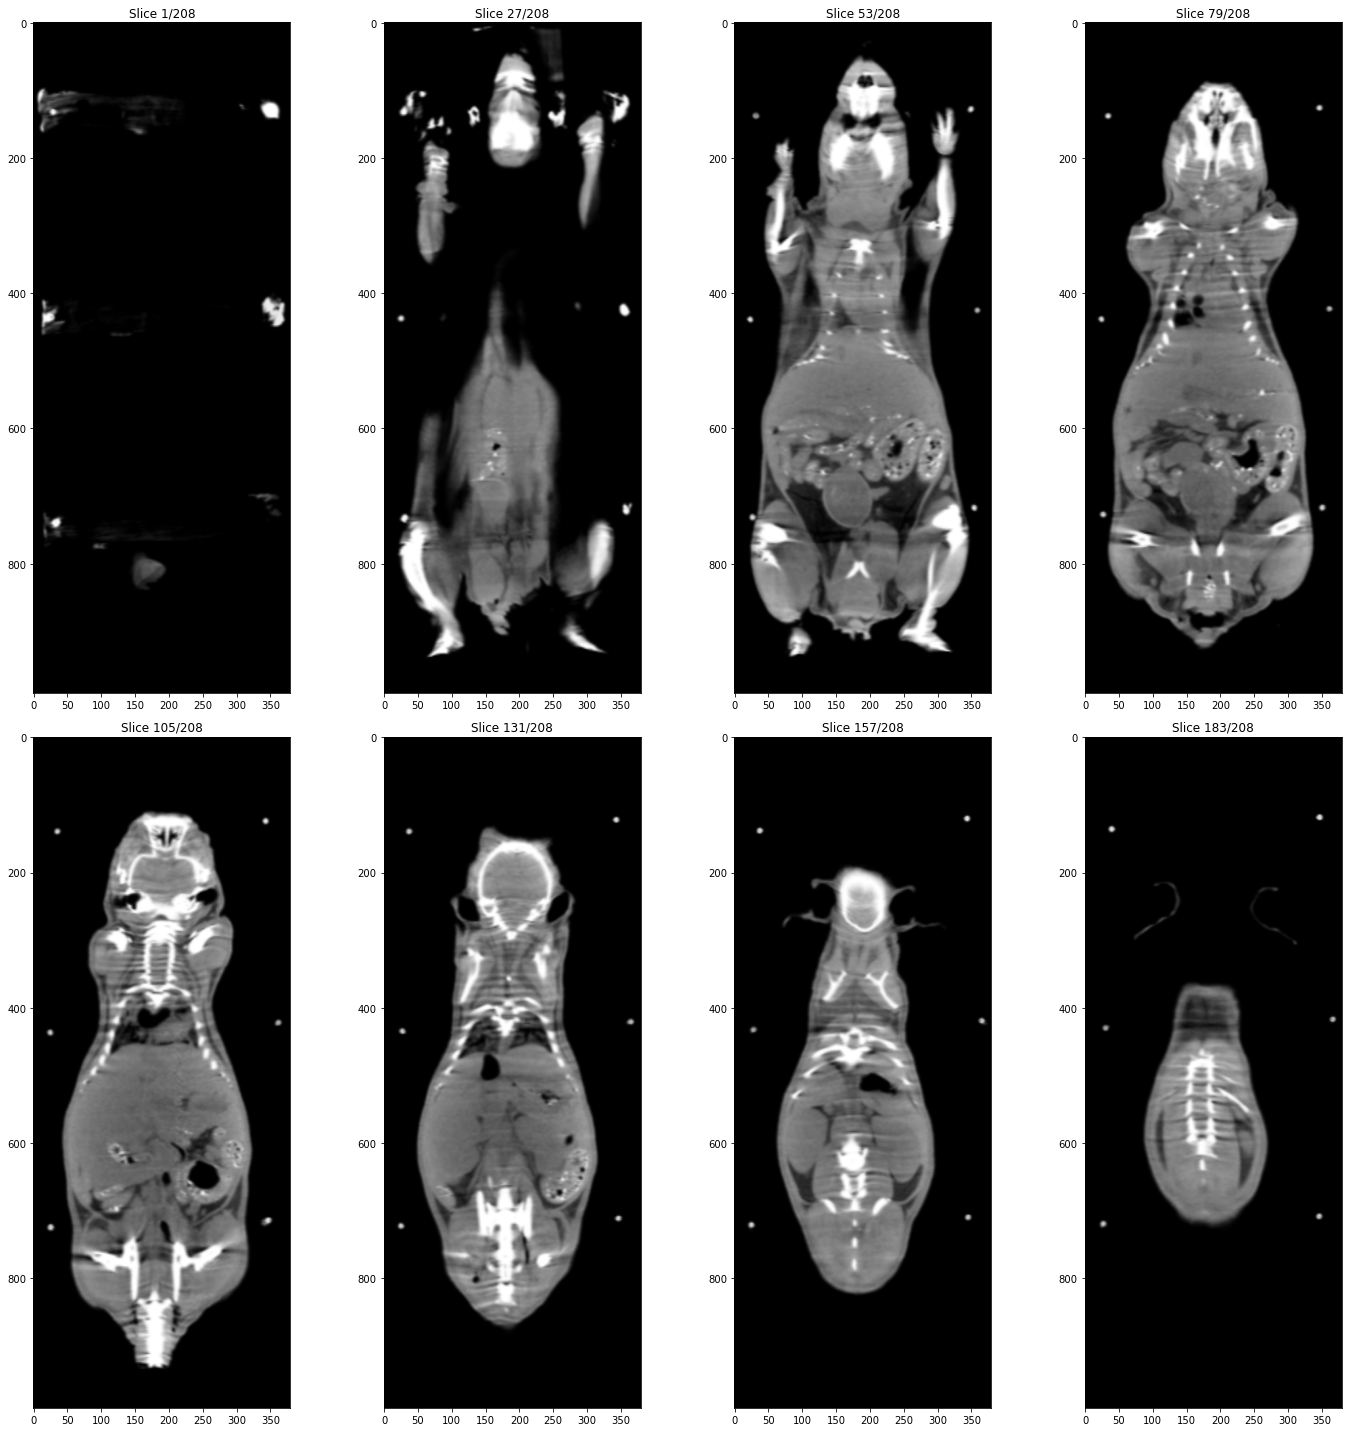

In [21]:
ncols = 4
nrows = 2

step = int(reference_CT_array.shape[0] / (ncols * nrows))
slices = range(0, int(reference_CT_array.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(reference_CT_array.shape[0]))
        ax.imshow(reference_CT_array[slice_id], cmap='gray')
        
plt.tight_layout()

## Create the STL files

Load the phantom

In [22]:
phantom = sitk.ReadImage("digimouse/atlas/atlas_380x992x208.hdr")
phantom_array = sitk.GetArrayFromImage(phantom)

NiftiImageIO (0x5569c25028b0): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 

NiftiImageIO (0x5569c25028b0): digimouse/atlas/atlas_380x992x208.hdr is Analyze file and it's deprecated 



Load the labels

In [23]:
df = pd.read_csv("digimouse/atlas/atlas_380x992x208.txt",
                 delimiter=" --> ",
                 names=["Label", "Organs"])

/home/fpvidal/miniconda3/envs/gvxr-validation/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Process every structure of the phantom

In [24]:
if not os.path.exists("digimouse/segmentations"):
    os.mkdir("digimouse/segmentations")

if not os.path.exists("digimouse/meshes"):
    os.mkdir("digimouse/meshes")

meshes = []
ground_truth_CT_in_mu = None
ct_phantom_fname = "gVirtualXRay_output_data/digimouse-phantom-mu511keV.mha"

for threshold, organ in zip(df["Label"], df["Organs"]):

    if organ == "air":
        mu_511_keV = 0.000104
    elif organ == "background":
        mu_511_keV = 0.0913
    elif organ == "skeleton":
        mu_511_keV = 0.1717
    elif organ == "eye":
        mu_511_keV = 0.1012
    elif organ == "medulla" or  organ == "olfactory bulbs" or  organ == "heart" or  organ == "lachrymal glands" or  organ == "bladder wall" or  organ == "stomach" or  organ == "spleen" or  organ == "pancreas" or  organ == "liver" or  organ == "kidneys" or  organ == "adrenal glands" or  organ == "skin":
        mu_511_keV = 0.1008
    elif organ == "cerebellum" or organ == "external cerebrum" or organ == "striatum" or organ == "rest of the brain" or organ == "whole brain":
        mu_511_keV = 0.0994
    elif organ == "testes"or organ == "testis":
        mu_511_keV = 0.0993
    elif organ == "masseter muscles":
        mu_511_keV = 0.0999
    elif organ == "lungs":
        mu_511_keV = 0.0999
    elif organ == "bladder":
        mu_511_keV = 0.096 
    elif organ == "tumors":
        mu_511_keV = 0.1008
    else:
        raise IOError("Unknown organ: " + organ)

    # Ignore air
    if organ != "whole brain" and organ != "background":
        organ = organ.replace(" ", "_")
        # print("Process", organ, threshold)
        
        seg_fname = "digimouse/segmentations/" + organ + ".mha"
        mesh_fname = "digimouse/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname) or not os.path.exists(ct_phantom_fname):
            
            print("        {")
            print("            \"Label\": \"" + organ + "\",")
            print("            \"Path\": \"" + mesh_fname + "\",")
            print("            \"Unit\": \"mm\",")

            # Only segment the image it is not done as yet
            if not os.path.exists(seg_fname):
            
                # Threshold the phantom
                binary_image = (phantom == threshold)
                
                # Pad the image

                filt = sitk.ConstantPadImageFilter()
                filt.SetConstant (0)
                filt.SetPadLowerBound ([1, 1, 1])
                filt.SetPadUpperBound ([1, 1, 1])
                binary_image = filt.Execute(binary_image)               
                
                sitk.WriteImage(binary_image, seg_fname)

                # # Smooth the binary segmentation
                # smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                # sitk.WriteImage(smoothed_binary_image, seg_fname)
            else:
                binary_image = sitk.ReadImage(seg_fname)
                # smoothed_binary_image = sitk.ReadImage(seg_fname)
                               
            binary_array = sitk.GetArrayFromImage(binary_image)
            
            
            test = binary_array > 0.5            
            # binary_array = sitk.GetArrayFromImage(smoothed_binary_image)
            # average_HU = reference_CT_array[test].mean()
    
            if ground_truth_CT_in_mu is None:
                ground_truth_CT_in_mu = np.zeros(binary_array.shape, dtype=np.single)

            ground_truth_CT_in_mu[test] = mu_511_keV
            
            print("            \"Material\": [\"mu\",", mu_511_keV, "],")
            # print("            \"Material\": [\"HU\",", average_HU, "],")
            print("            \"Type\": \"inner\",")
            print("            \"Opacity\": 0.4")
            print("        },")
            print()

            if not os.path.exists(mesh_fname):

                # Create a VTK image
                vtkimg = sitk2vtk(binary_image, centre=True)
                # vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

                # binary_array = sitk.GetArrayFromImage(binary_image)
                min_val = binary_array.min()
                max_val = binary_array.max()
                threshold = min_val + 0.5 * (max_val - min_val)

                vtkmesh = extractSurface(vtkimg, threshold)

                writeSTL(vtkmesh, mesh_fname)

In [25]:
del phantom

## Save the ground truth volume

In [26]:
if not os.path.exists(ct_phantom_fname):
    
    # Crop
    ground_truth_CT_in_mu = ground_truth_CT_in_mu[1:reference_CT_array.shape[0]+1, 1:reference_CT_array.shape[1]+1, 1:reference_CT_array.shape[2]+1].astype(np.single)
    
    sitk_image = sitk.GetImageFromArray(ground_truth_CT_in_mu)
    sitk_image.SetSpacing(reference_CT_volume.GetSpacing())
    sitk.WriteImage(sitk_image, ct_phantom_fname, useCompression=True)
    
else:
    temp = sitk.ReadImage(ct_phantom_fname)
    ground_truth_CT_in_mu = sitk.GetArrayFromImage(temp)                                 

## Display the ground truth

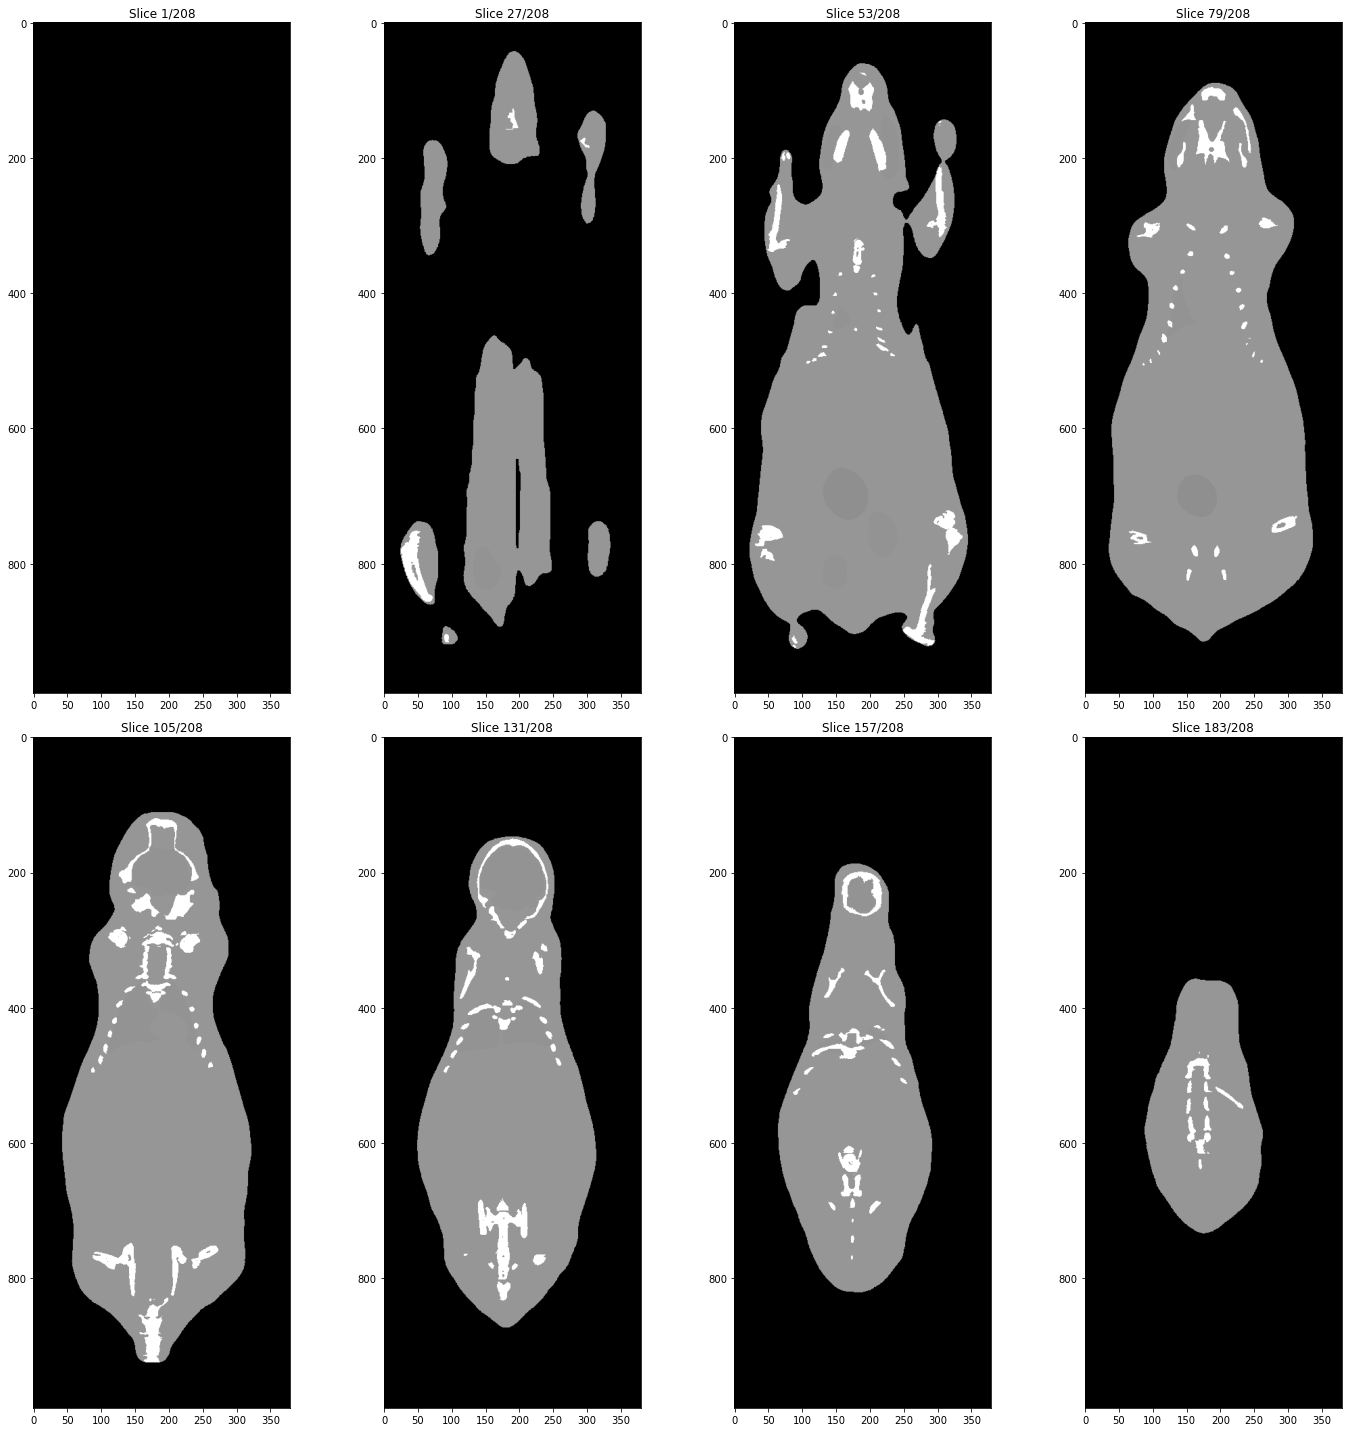

In [27]:
ncols = 4
nrows = 2

step = int(ground_truth_CT_in_mu.shape[0] / (ncols * nrows))
slices = range(0, int(ground_truth_CT_in_mu.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(ground_truth_CT_in_mu.shape[0]))
        ax.imshow(ground_truth_CT_in_mu[slice_id], cmap='gray')
        
plt.tight_layout()

## Compute the ground truth as a set of projections

In [28]:
proj_fname = "gVirtualXRay_output_data/digimouse-phantom-proj-511keV.mha"
sino_fname = "gVirtualXRay_output_data/digimouse-phantom-sinogram-511keV.mha"

if not os.path.exists(proj_fname) or not os.path.exists(sino_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        ground_truth_proj, ground_truth_sino = projsFromPhantom(ground_truth_CT_in_mu, theta_deg, mode="parallel", backend="scikit-image")
    
    # Tomopy or Tigre
    else:
        ground_truth_proj, ground_truth_sino = projsFromPhantom(ground_truth_CT_in_mu, theta_deg, mode="parallel", backend=tomography_backend)    
    
    sitk_image = sitk.GetImageFromArray(ground_truth_proj)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, proj_fname, useCompression=True)
    
    sitk_image = sitk.GetImageFromArray(ground_truth_sino)
    sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
    sitk.WriteImage(sitk_image, sino_fname, useCompression=True)
else:
    
    temp = sitk.ReadImage(proj_fname)
    ground_truth_proj = sitk.GetArrayFromImage(temp)      
    
    temp = sitk.ReadImage(sino_fname)
    ground_truth_sino = sitk.GetArrayFromImage(temp)                                 

In [29]:
ground_truth_sino_min = ground_truth_sino.min()
ground_truth_sino_max = ground_truth_sino.max()

Draw the projection

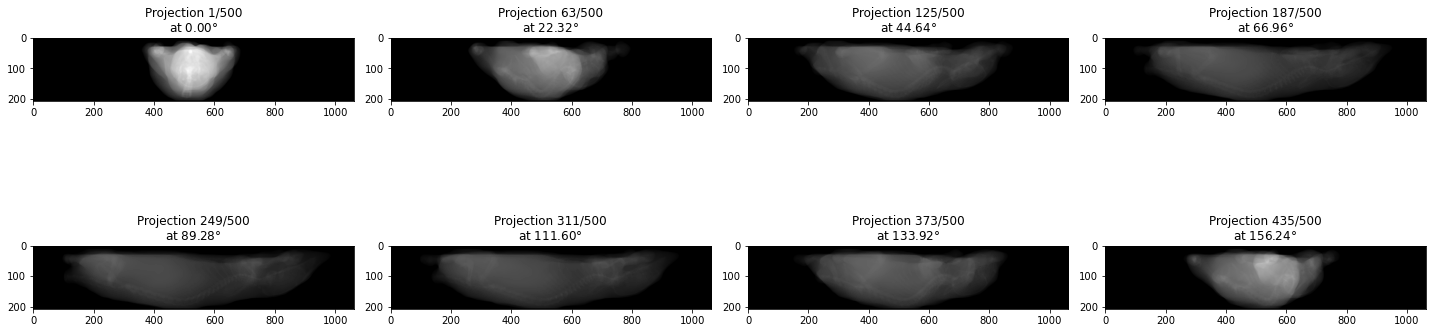

In [30]:
ncols = 4
nrows = 2

step = int(ground_truth_proj.shape[0] / (ncols * nrows))
slices = range(0, int(ground_truth_proj.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(ground_truth_proj.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(ground_truth_proj[slice_id], cmap='gray', vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
 
plt.tight_layout()

Draw the sinograms

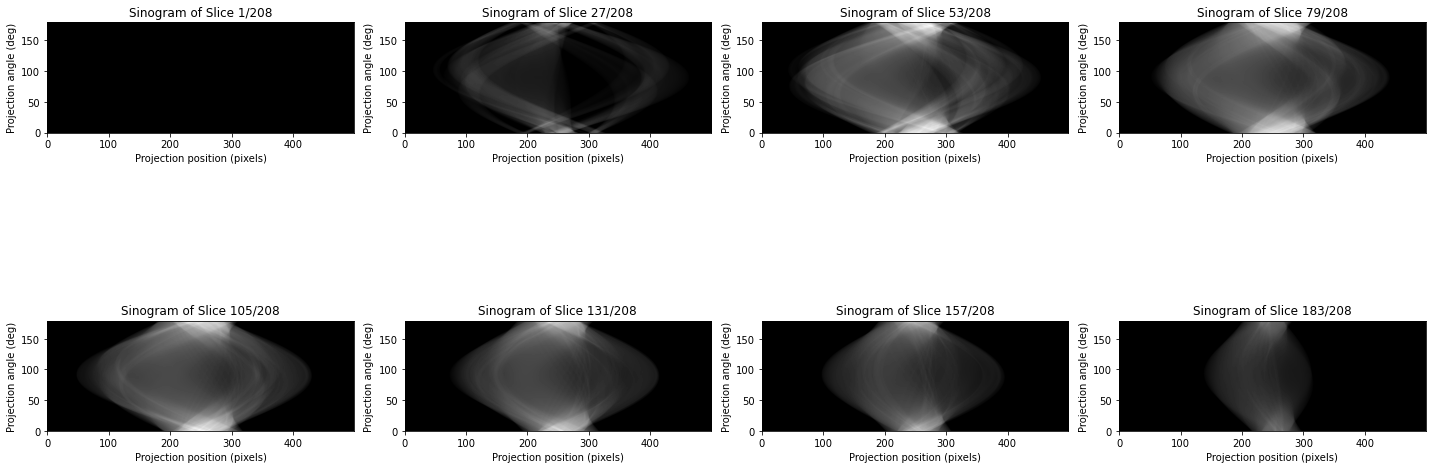

In [31]:
ncols = 4
nrows = 2

step = int(ground_truth_sino.shape[0] / (ncols * nrows))
slices = range(0, int(ground_truth_sino.shape[0]), step)

fig = plt.figure(figsize= (20, 10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(ground_truth_sino.shape[0]))
        ax.imshow(ground_truth_sino[slice_id],
                  extent=[0, ground_truth_sino.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
 
plt.tight_layout()

## CT reconstruction of the ground truth sinogram

In [32]:
ref_fname = "gVirtualXRay_output_data/digimouse_ground_truth_CT_recons_in_mu.mha"

if not os.path.exists(ref_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        ground_truth_CT_recons_in_mu = recons(ground_truth_sino,
                                              theta_deg,  
                                              "parallel",
                                              "hann",
                                              reference_CT_array.shape[2],
                                              reference_CT_array.shape[1],
                                              reference_CT_array.shape[0],
                                              tomography_backend)
    
    # Tomopy or Tigre
    else:
        ground_truth_CT_recons_in_mu = recons(ground_truth_proj,
                                          theta_deg,  
                                          "parallel", 
                                          "hann", 
                                          reference_CT_array.shape[2], 
                                          reference_CT_array.shape[1], 
                                          reference_CT_array.shape[0], 
                                          tomography_backend)
    
    del ground_truth_sino # No longer needed
    
    sitk_image = sitk.GetImageFromArray(ground_truth_CT_recons_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * ground_truth_proj.shape[2] / 2.0,
                          -pixel_width * ground_truth_proj.shape[1] / 2.0,
                          -pixel_height * ground_truth_proj.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, ref_fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(ref_fname)
    ground_truth_CT_recons_in_mu = sitk.GetArrayFromImage(sitk_image)

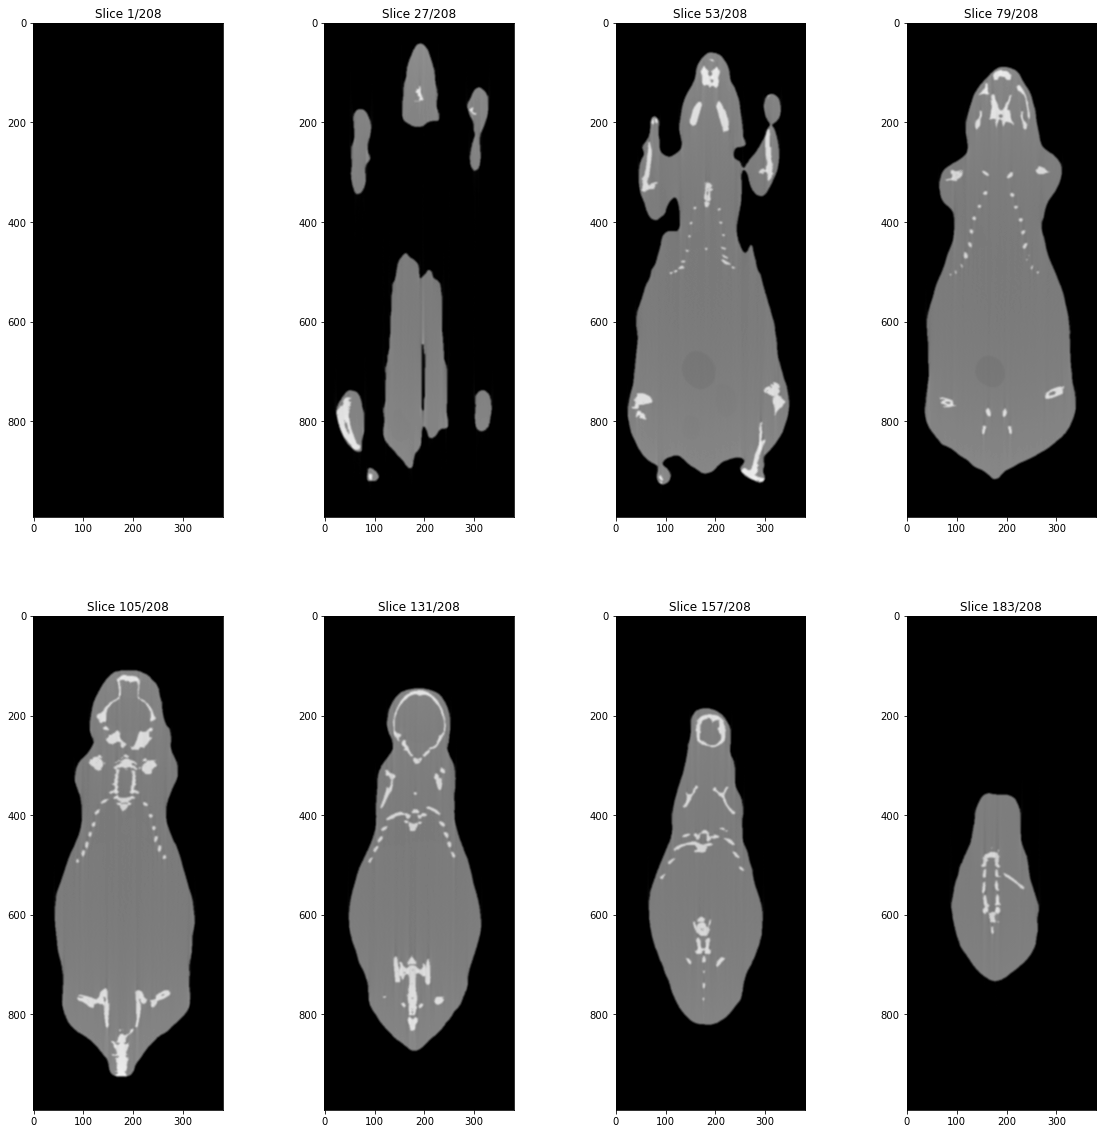

In [33]:
ncols = 4
nrows = 2

step = int(ground_truth_CT_recons_in_mu.shape[0] / (ncols * nrows))
slices = range(0, int(ground_truth_CT_recons_in_mu.shape[0]), step)

fig = plt.figure(figsize= (20,20))
# plt.suptitle("CT reconstruction of the ground truth sinogram")
for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(ground_truth_CT_recons_in_mu.shape[0]))
        ax.imshow(ground_truth_CT_recons_in_mu[slice_id], cmap='gray', vmin=0, vmax=ground_truth_CT_recons_in_mu.max())
        
# plt.tight_layout()

## Scanned object

We load the surface meshes. Their linear attenuation coefficient in cm<sup>-1</sup> are for 511 keV.

In [34]:
json2gvxr.initSamples(verbose=0)

file_name:	digimouse/meshes/skin.stl	nb_faces:	3865300	nb_vertices:	11595900	bounding_box (in cm):	(-1.72, -4.55, -0.95)	(1.56, 4.33, 1.02)
file_name:	digimouse/meshes/skeleton.stl	nb_faces:	1417512	nb_vertices:	4252536	bounding_box (in cm):	(-1.68, -4.21, -0.88)	(1.5, 4.32, 0.99)
file_name:	digimouse/meshes/eye.stl	nb_faces:	5548	nb_vertices:	16644	bounding_box (in cm):	(-0.44, -3.54, -0.14)	(0.49, -3.31, 0.12)
file_name:	digimouse/meshes/medulla.stl	nb_faces:	24196	nb_vertices:	72588	bounding_box (in cm):	(-0.29, -2.66, -0.02)	(0.31, -1.91, 0.3)
file_name:	digimouse/meshes/cerebellum.stl	nb_faces:	19532	nb_vertices:	58596	bounding_box (in cm):	(-0.39, -2.62, 0.25)	(0.39, -2.25, 0.54)
file_name:	digimouse/meshes/olfactory_bulbs.stl	nb_faces:	11892	nb_vertices:	35676	bounding_box (in cm):	(-0.14, -3.64, -0.09)	(0.21, -3.26, 0.19)
file_name:	digimouse/meshes/external_cerebrum.stl	nb_faces:	79252	nb_vertices:	237756	bounding_box (in cm):	(-0.49, -3.39, -0.15)	(0.48, -2.6, 0.53)
file_name

In [35]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
    print(label, \
          "has", \
          f"{number_of_triangles_in_mesh:,}", \
          "triangles. Its mu coefficient is", \
          gvxr.getLinearAttenuationCoefficient(label, 511, "keV"))

print("\nThere are", f"{number_of_triangles:,}", "triangles in total")

skin has 3,865,300 triangles. Its mu coefficient is 0.1008
skeleton has 1,417,512 triangles. Its mu coefficient is 0.17169999999999996
eye has 5,548 triangles. Its mu coefficient is 0.1012
medulla has 24,196 triangles. Its mu coefficient is 0.1008
cerebellum has 19,532 triangles. Its mu coefficient is 0.0994
olfactory_bulbs has 11,892 triangles. Its mu coefficient is 0.1008
external_cerebrum has 79,252 triangles. Its mu coefficient is 0.0994
striatum has 18,852 triangles. Its mu coefficient is 0.0994
heart has 59,536 triangles. Its mu coefficient is 0.1008
rest_of_the_brain has 118,392 triangles. Its mu coefficient is 0.0994
masseter_muscles has 56,812 triangles. Its mu coefficient is 0.0999
lachrymal_glands has 20,072 triangles. Its mu coefficient is 0.1008
bladder has 48,740 triangles. Its mu coefficient is 0.096
testis has 52,964 triangles. Its mu coefficient is 0.09929999999999999
stomach has 67,144 triangles. Its mu coefficient is 0.1008
spleen has 64,948 triangles. Its mu coeffic

In [36]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    if label != "background":
        fname = sample["Path"]

        r, g, b, a = gvxr.getAmbientColour(label)
        R = math.floor(255*r)
        G = math.floor(255*g)
        B = math.floor(255*b)
        A = math.floor(255*a)
        print(fname, R, G,B,A)
        k3d_color = 0;
        k3d_color |= (R & 255) << 16;
        k3d_color |= (G & 255) << 8;
        k3d_color |= (B & 255);

        mesh_from_stl_file = mesh.Mesh.from_file(fname)

        if label == "skin":
            opacity = 0.2
        else:
            opacity = 1
        geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                              range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                              color=k3d_color, 
                              wireframe=False, 
                              flat_shading=False,
                              name=fname,
                              opacity=opacity)

        plot += geometry   
    
plot.display()
plot.camera = [51.70138935468283, -33.56634373137791, 19.350072896599926,
               0, 0, 0,
               -0.2256588430434781, 0.1042012706726087, 0.9686176654111467]

digimouse/meshes/skin.stl 31 119 180 51
digimouse/meshes/skeleton.stl 255 127 14 178
digimouse/meshes/eye.stl 44 160 44 102
digimouse/meshes/medulla.stl 214 39 40 102
digimouse/meshes/cerebellum.stl 148 103 189 102
digimouse/meshes/olfactory_bulbs.stl 140 86 75 102
digimouse/meshes/external_cerebrum.stl 227 119 194 102
digimouse/meshes/striatum.stl 127 127 127 102
digimouse/meshes/heart.stl 188 189 34 102
digimouse/meshes/rest_of_the_brain.stl 23 190 207 102
digimouse/meshes/masseter_muscles.stl 31 119 180 102
digimouse/meshes/lachrymal_glands.stl 255 127 14 102
digimouse/meshes/bladder.stl 44 160 44 102
digimouse/meshes/testis.stl 214 39 40 102
digimouse/meshes/stomach.stl 148 103 189 102
digimouse/meshes/spleen.stl 140 86 75 102
digimouse/meshes/pancreas.stl 227 119 194 102
digimouse/meshes/liver.stl 127 127 127 102
digimouse/meshes/kidneys.stl 188 189 34 102
digimouse/meshes/adrenal_glands.stl 23 190 207 102
digimouse/meshes/lungs.stl 31 119 180 102


Output()

In [37]:
fname = 'digimouse_visualisation.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [38]:
gvxr.displayScene()
gvxr.displayScene()
temp = gvxr.computeXRayImage()

0 0 500 500
0 0 800 450


In [39]:
gvxr.useNegative()
gvxr.useLighing()
gvxr.useWireframe(False)
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering()

gvxr.setWindowBackGroundColour(1, 1, 1)

gvxr.setZoom(237.098388671875)
gvxr.setSceneRotationMatrix([math.cos(math.pi / 2), -math.sin(math.pi / 2), 0, 0,
                             math.sin(math.pi / 2), math.cos(math.pi / 2), 0, 0,
                             0, 0, 1, 0,
                             0, 0, 0, 1])

gvxr.displayScene()
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)
plt.imsave("digimouse_3d-env.png", screenshot)

In [40]:
gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.useNegative()
gvxr.useLighing()
gvxr.useWireframe(False)
gvxr.setZoom(280)
gvxr.setSceneRotationMatrix([-0.9056491851806641, -0.057583823800086975, 0.4200952649116516, 0.0,
    0.42298418283462524, -0.19202931225299835, 0.8855555057525635, 0.0,
    0.029676731675863266, 0.9796957969665527, 0.19826850295066833, 0.0,
    0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

In [41]:
screenshot = gvxr.takeScreenshot()

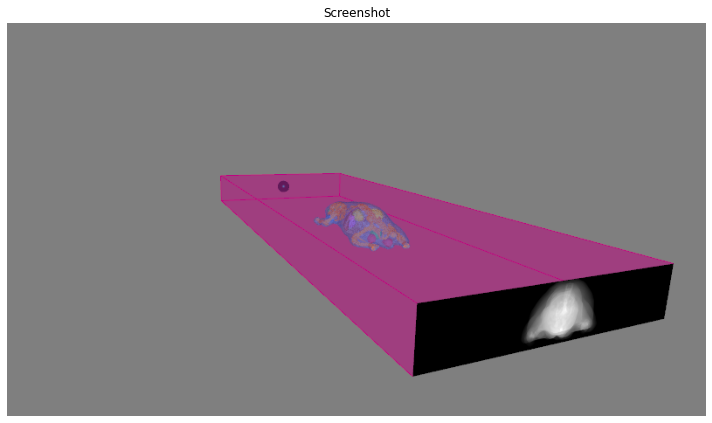

In [42]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-on-digimouse.pdf')
plt.savefig('plots/screenshot-beam-on-digimouse.png')

 Update set of projections while rotating the scene to mimick CT acquisition

In [43]:
%%capture

raw_projections = [];
angles = [];
runtimes = []

# Create a GIF file
writer = None
fname_gif = "plots/digimouse_acquisition.gif"

if not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

# Save the transformation matrix
transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

rotation_axis = json2gvxr.params["Detector"]["UpVector"]

for angle_id in range(0, number_of_projections):

    # Add the rotation angle, starting from 0
    angles.append(angle_id * angular_step)
        
    # Compute an X-ray image
    # xray_image = np.array(gvxr.computeXRayImage());
    start_time = datetime.datetime.now()
    
    xray_image = gvxr.computeXRayImage()
    
    # if xray_image.shape != [208, 1062]:
    #     xray_image = resize(xray_image, [208, 1062])
    
    # xray_image = np.array(gvxr.computeXRayImage());
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)
    
    # Add to the set of projections
    raw_projections.append(xray_image)
    
    # Update the rendering
    gvxr.displayScene();

    # Take a screenshot
    if writer is not None:
        if not angle_id % 30:
            screenshot = gvxr.takeScreenshot()

            plt.figure(figsize= (10,10))
            plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
            plt.imshow(screenshot)
            plt.axis('off')

            plt.tight_layout()

            plt.savefig('temp.png')            
            plt.close()
            
            
            image = imageio.imread("temp.png")
            writer.append_data(image)

    # Rotate the sample
    gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])
    
# We're done with the writer
if writer is not None:
    writer.close()
    os.remove("temp.png")

# Convert to numpy arrays
raw_projections = np.array(raw_projections)

# Restore the transformation matrix
gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

# Update the rendering
gvxr.displayScene();

In [44]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

# Perform flat-field correction

In [45]:
fname = "gVirtualXRay_output_data/digimouse_flat.mha"
if not os.path.exists(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)
    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)
    
del raw_projections # Not needed anymore

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [46]:
fname = "gVirtualXRay_output_data/digimouse_minus_log_projs.mha"

if not os.path.exists(fname):

    minus_log_projs = minusLog(corrected_projections)

    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

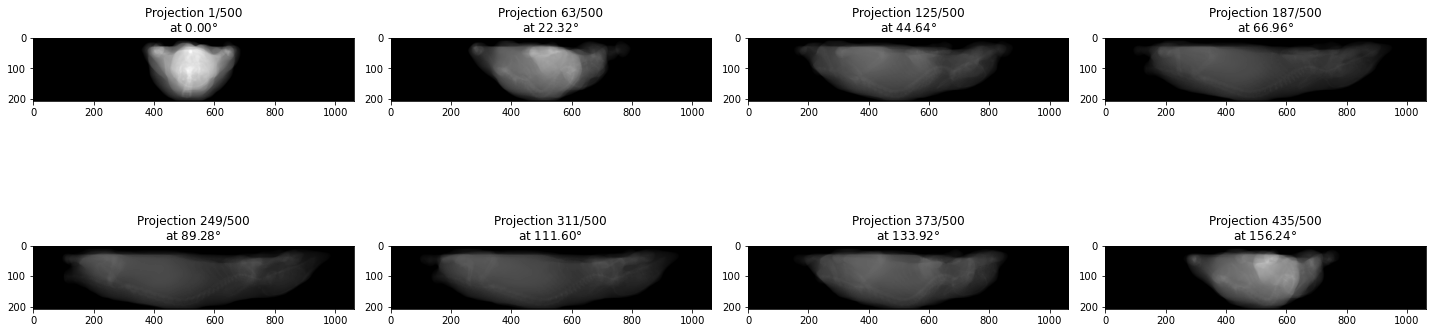

In [47]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(theta_deg[slice_id]) + "\degree$")
        ax.imshow(minus_log_projs[slice_id], cmap='gray', vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
 
plt.tight_layout()

In [48]:
fname = "gVirtualXRay_output_data/digimouse_sinograms.mha"

if not os.path.exists(fname):
    
    sino_shape = [
        minus_log_projs.shape[1],
        minus_log_projs.shape[0],
        minus_log_projs.shape[2]
    ]
    
    sinograms = np.zeros(sino_shape).astype(np.single)
    
    for angle_id in range(minus_log_projs.shape[0]):
        for slice_id in range(minus_log_projs.shape[1]):
            sinograms[slice_id, angle_id] = minus_log_projs[angle_id, slice_id]

    # Save
    sitk_image = sitk.GetImageFromArray(sinograms)
    sitk_image.SetSpacing([pixel_width, angular_step, pixel_height])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    sinograms = sitk.GetArrayFromImage(temp)

Plot some sinograms

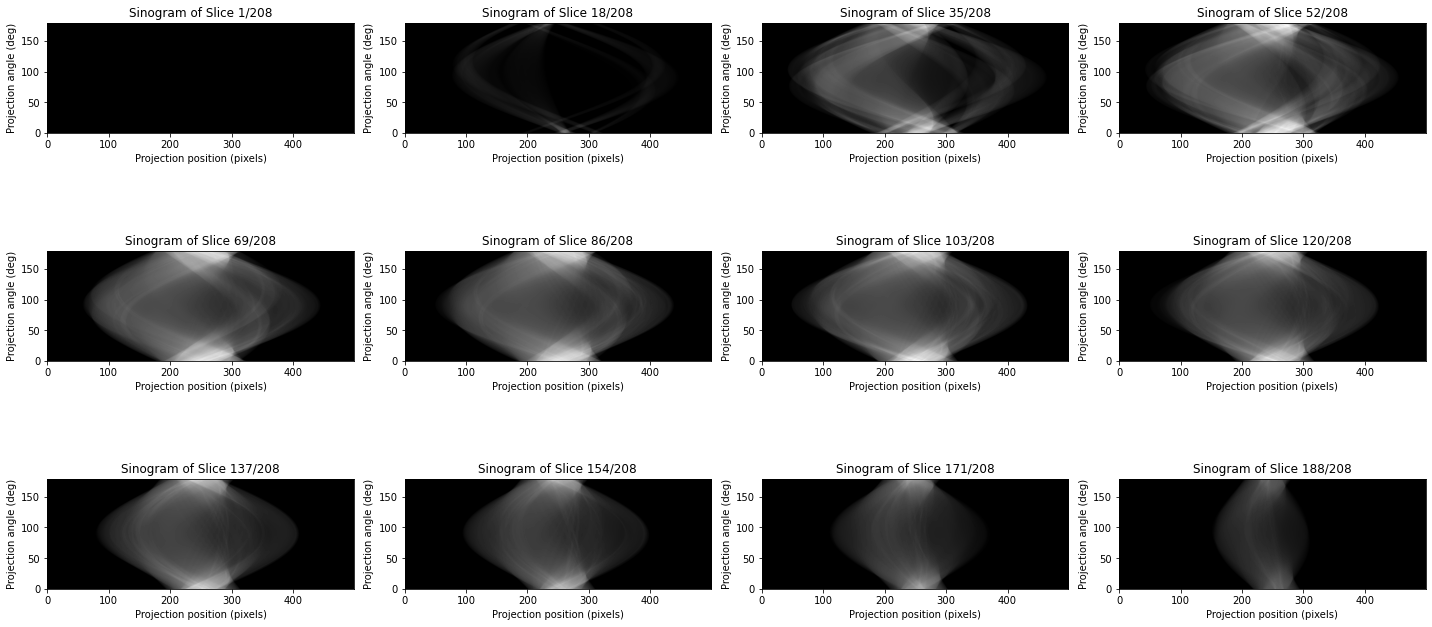

In [49]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id],
                  extent=[0, sinograms.shape[1] - 1, theta_deg[0], theta_deg[-1]],
                  cmap='gray',
                  vmin=ground_truth_sino_min, vmax=ground_truth_sino_max)
        ax.set_xlabel("Projection position (pixels)")
        ax.set_ylabel("Projection angle (deg)")
        
plt.tight_layout()

## CT reconstruction of the simulated sinogram

In [50]:
simu_fname = "gVirtualXRay_output_data/digimouse_simu_CT_recons_in_mu.mha"

if not os.path.exists(simu_fname) or not os.path.exists(ref_fname):

    # Scikit-Image
    if tomography_backend == "scikit-image":
        CT_volume_in_mu = recons(sinograms,
                                  theta_deg,  
                                  "parallel",
                                  "hann",
                                  reference_CT_array.shape[2],
                                  reference_CT_array.shape[1],
                                  reference_CT_array.shape[0],
                                  tomography_backend)
    
    # Tomopy or Tigre
    else:
        CT_volume_in_mu = recons(minus_log_projs,
                                  theta_deg,  
                                  "parallel", 
                                  "hann", 
                                  reference_CT_array.shape[2], 
                                  reference_CT_array.shape[1], 
                                  reference_CT_array.shape[0], 
                                  tomography_backend) 
        
    sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * CT_volume_in_mu.shape[2] / 2.0,
                          -pixel_width * CT_volume_in_mu.shape[1] / 2.0,
                          -pixel_height * CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, simu_fname, useCompression=True)

else:
    sitk_image = sitk.ReadImage(simu_fname)
    CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

del reference_CT_array # Not needed anymore
del sinograms # Not needed anymore

## Display the CT slices

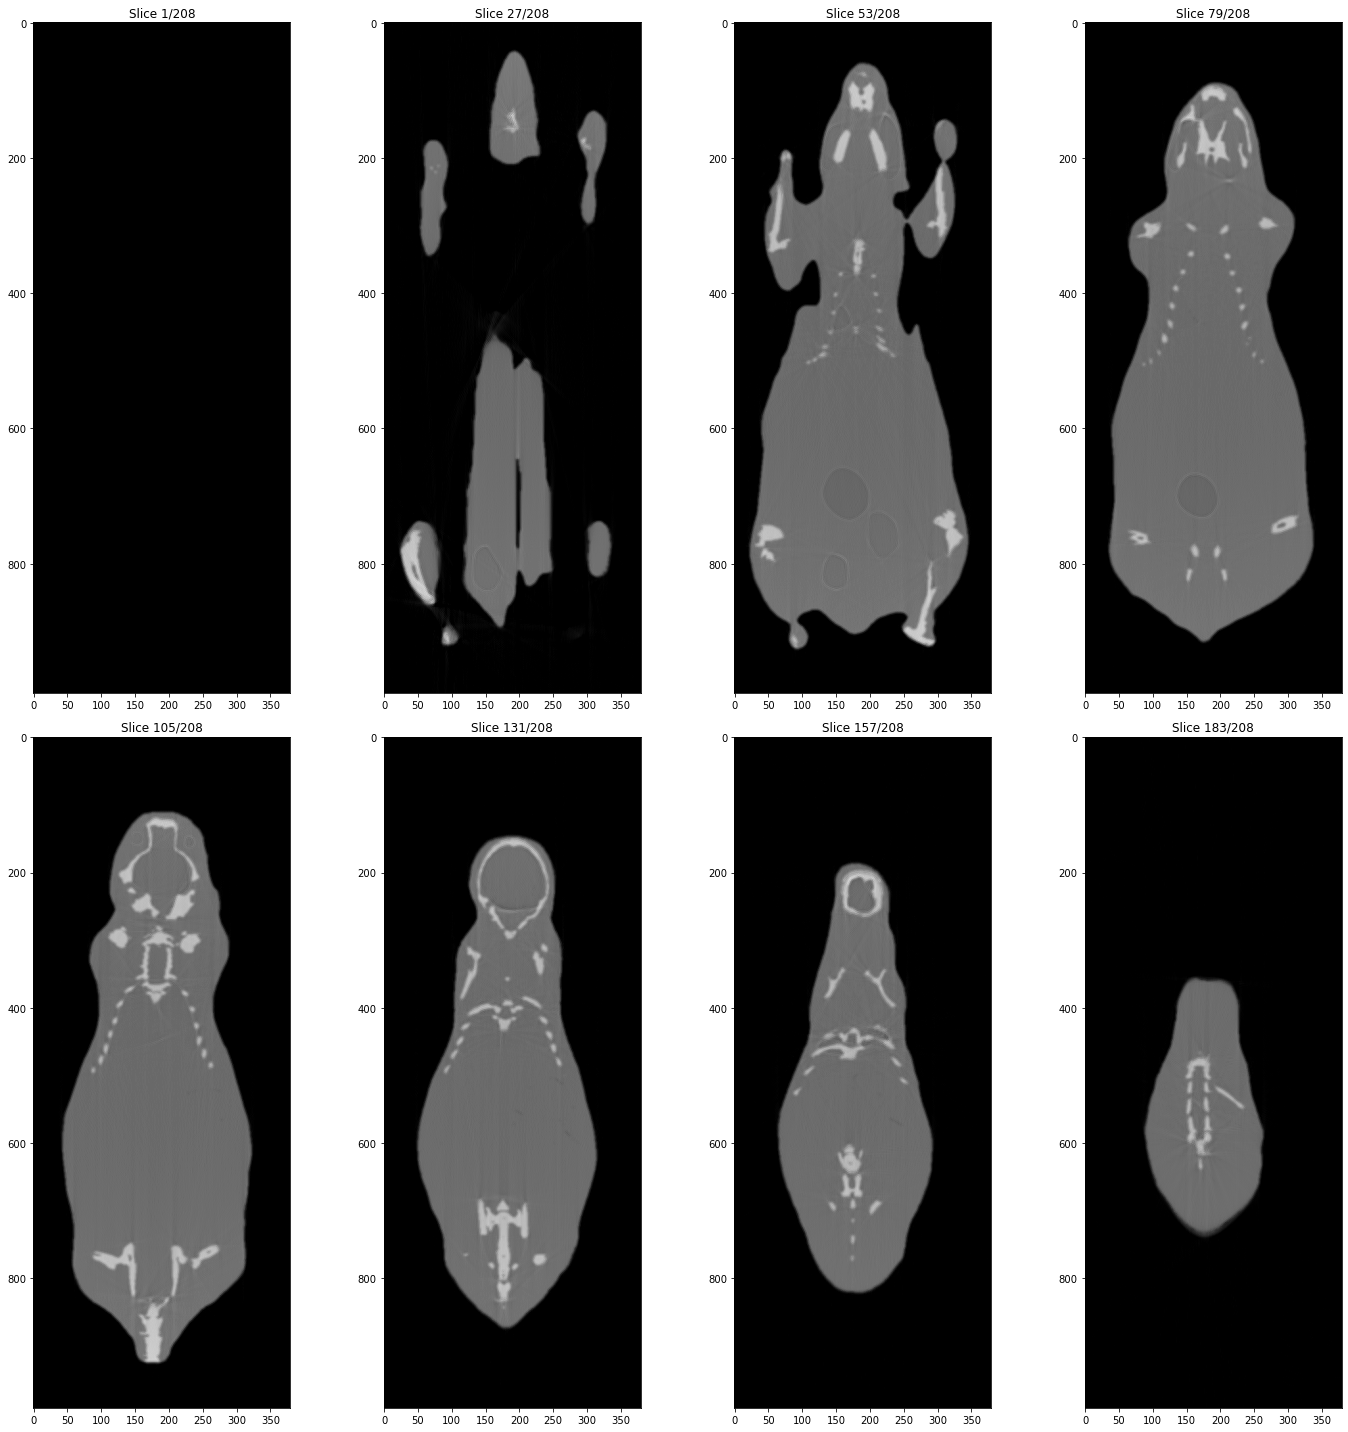

In [51]:
ncols = 4
nrows = 2

step = int(CT_volume_in_mu.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume_in_mu.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume_in_mu.shape[0]))
        #ax.imshow(np.rot90(CT_volume_in_mu[slice_id]), cmap='gray', vmin=0, vmax=CT_volume_in_mu.max())
        ax.imshow(CT_volume_in_mu[slice_id], cmap='gray', vmin=0, vmax=CT_volume_in_mu.max())
        
plt.tight_layout()

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls ($\le$ 0.28783056). Using the MAPE would lead to large errors for these reasons.

3200 angles
ZNCC: 98.97%
SSIM: 0.62

### CT reconstruction from ground truth sinograms vs phantom

In [52]:
ZNCC_CT = np.mean((ground_truth_CT_in_mu - ground_truth_CT_in_mu.mean()) / ground_truth_CT_in_mu.std() * (ground_truth_CT_recons_in_mu - ground_truth_CT_recons_in_mu.mean()) / ground_truth_CT_recons_in_mu.std())
SSIM_CT = ssim(ground_truth_CT_in_mu, ground_truth_CT_recons_in_mu, data_range=ground_truth_CT_in_mu.max() - ground_truth_CT_in_mu.min())

print("ZNCC:", "{0:0.2f}".format(100 * ZNCC_CT) + "%")
print("SSIM:", "{0:0.2f}".format(SSIM_CT))

ZNCC: 99.25%
SSIM: 0.61


### CT reconstruction from simulated sinograms vs phantom

In [53]:
ZNCC_CT = np.mean((ground_truth_CT_in_mu - ground_truth_CT_in_mu.mean()) / ground_truth_CT_in_mu.std() * (CT_volume_in_mu - CT_volume_in_mu.mean()) / CT_volume_in_mu.std())
SSIM_CT = ssim(ground_truth_CT_in_mu, CT_volume_in_mu, data_range=ground_truth_CT_in_mu.max() - ground_truth_CT_in_mu.min())

print("ZNCC:", "{0:0.2f}".format(100 * ZNCC_CT) + "%")
print("SSIM:", "{0:0.2f}".format(SSIM_CT))

ZNCC: 99.07%
SSIM: 0.57


In [54]:
del ground_truth_CT_in_mu

### CT reconstruction from simulated sinograms vs CT reconstruction from ground truth sinograms

In [55]:
ZNCC_CT = np.mean((ground_truth_CT_recons_in_mu - ground_truth_CT_recons_in_mu.mean()) / ground_truth_CT_recons_in_mu.std() * (CT_volume_in_mu - CT_volume_in_mu.mean()) / CT_volume_in_mu.std())
SSIM_CT = ssim(ground_truth_CT_recons_in_mu, CT_volume_in_mu, data_range=ground_truth_CT_recons_in_mu.max() - ground_truth_CT_recons_in_mu.min())

print("ZNCC:", "{0:0.2f}".format(100 * ZNCC_CT) + "%")
print("SSIM:", "{0:0.2f}".format(SSIM_CT))

ZNCC: 99.80%
SSIM: 0.92


In [56]:
del ground_truth_CT_recons_in_mu
del CT_volume_in_mu

### simulated projections vs ground truth sinograms

In [57]:
ZNCC_sinogram = np.mean((ground_truth_proj - ground_truth_proj.mean()) / ground_truth_proj.std() * (minus_log_projs - minus_log_projs.mean()) / minus_log_projs.std())
SSIM_sinogram = ssim(ground_truth_proj, minus_log_projs, data_range=ground_truth_proj.max() - ground_truth_proj.min())

print("ZNCC:", "{0:0.2f}".format(100 * ZNCC_sinogram) + "%")
print("SSIM:", "{0:0.2f}".format(SSIM_sinogram))

ZNCC: 100.00%
SSIM: 1.00


Print a row of the table for the paper

In [58]:
print("Digimouse CT acquisition & Synthetic volume & " + 
      "N/A    &    " +
      "{0:0.2f}".format(100 * ZNCC_sinogram) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_sinogram) + "    &    $" +
      str(ground_truth_proj.shape[2]) + " \\times " + str(ground_truth_proj.shape[1]) + " \\times " + str(ground_truth_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Digimouse CT acquisition & Synthetic volume & N/A    &    100.00\%    &    1.00    &    $1062 \times 208 \times 500$    &    6678588    &    $25 \pm 7$ \\


In [59]:
print("Digimouse CT reconstruction & Synthetic volume & " + 
      "N/A    &    " +
      "{0:0.2f}".format(100 * ZNCC_CT) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_CT) + "    &    $" +
      str(ground_truth_proj.shape[2]) + " \\times " + str(ground_truth_proj.shape[1]) + " \\times " + str(ground_truth_proj.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Digimouse CT reconstruction & Synthetic volume & N/A    &    99.80\%    &    0.92    &    $1062 \times 208 \times 500$    &    6678588    &    $25 \pm 7$ \\


Both the ZNCC and SSIM are very high (~99% for ZNCC and 0.58 for SSIM). We can conclude that the two images are similar.

### Qualitative validation

In [60]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

(208,)


(75.0, 133.0)

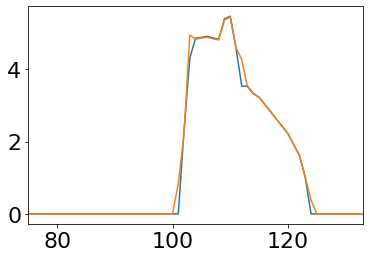

In [61]:
ref_diag = np.diag(ground_truth_proj[minus_log_projs.shape[0] // 2])
test_diag = np.diag(minus_log_projs[minus_log_projs.shape[0] // 2])
print(test_diag.shape)

plt.figure()
plt.plot(ref_diag)
plt.plot(test_diag)
plt.xlim((75, test_diag.shape[0] - 75))

In [62]:
del ground_truth_proj # Not needed anymore
del minus_log_projs # Not needed anymore

Shutdown the simulation

In [63]:
gvxr.destroyAllWindows();

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x5569c44ae200)
